In [4]:
"""Optimized version of evaluate_model.ipynb

This notebook allows for hyperparameters to be passed for more automation.
(v2 refactors code to reuse the TF-IDF matrix and transformer embeddings once they have been generated if RANDOM=False)

An output file will be written into a folder named "output".

Example output: output/logreg_tf_0_C1_tol0.0001_mi500.txt
- interpretation: Logistic Regression on a TF-IDF matrix, using class weight balancing and the following parameters: C=1, tol=0.0001, and max_iter=500
"""

import time
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report, roc_auc_score#, roc_curve
from sklearn.preprocessing import label_binarize
#import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from scipy.sparse import hstack, csr_matrix

# SCRIPT_DIR = Path(__file__).resolve()
SCRIPT_DIR = Path("")

SEED = 42

# parameters:
RANDOM = False
IMBALANCE = 0  # 0=class_weight, 1=undersampling
FEATURE = 0  # 0=TF-IDF, 1=embedding, 2=both
MODEL = 0  # 0=LogReg, 1=XGB, 2=RF

# store features to reuse
TRAIN_TF_IDF = None
TEST_TF_IDF = None
TRAIN_EMBEDDINGS = None
TEST_EMBEDDINGS = None

# 2nd version of feature variables if data is being undersampled
TRAIN_TF_IDF2 = None
TEST_TF_IDF2 = None
TRAIN_EMBEDDINGS2 = None
TEST_EMBEDDINGS2 = None

def load_data():
    """
    Returns train/test dataframes:
    - train_df,
    - test_df,
    - test_labels_df
    """
    data_path = "data"
    train_filename = "train.csv"
    test_filename = "test.csv"
    test_labels_filename = "test_labels.csv"

    train_df = pd.read_csv(SCRIPT_DIR / data_path / train_filename)
    test_df = pd.read_csv(SCRIPT_DIR / data_path / test_filename)
    test_labels_df = pd.read_csv(SCRIPT_DIR / data_path / test_labels_filename)

    # ignore test values with -1 labels
    test_df_usable = test_df.loc[test_labels_df['toxic'] != -1]
    test_labels_df_usable = test_labels_df.loc[test_labels_df['toxic'] != -1]

    return train_df, test_df_usable, test_labels_df_usable


def undersample(combined_X, combined_y):
    """Undersample comments with no positive labels"""
    neg_indices = combined_y[(combined_y == 0).all(axis=1)].index.tolist()
    pos_indices = combined_y[(combined_y != 0).any(axis=1)].index.tolist()

    if RANDOM == False:
        np.random.seed(SEED)

    neg_indices = np.random.choice(neg_indices, len(pos_indices), replace=False)

    test_size = 0.2
    split_point = int(test_size * len(neg_indices))
    np.random.shuffle(neg_indices)
    np.random.shuffle(pos_indices)
    train_indices = np.concat([neg_indices[split_point:], pos_indices[split_point:]])
    test_indices = np.concat([neg_indices[:split_point], pos_indices[:split_point]])
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    # establish train and test datasets
    train_X = combined_X.iloc[train_indices]
    test_X = combined_X.iloc[test_indices]
    train_y = combined_y.iloc[train_indices]
    test_y = combined_y.iloc[test_indices]
    return train_X, test_X, train_y, test_y


def get_features(train_X, test_X):
    global TRAIN_TF_IDF, TEST_TF_IDF, TRAIN_EMBEDDINGS, TEST_EMBEDDINGS, TRAIN_TF_IDF2, TEST_TF_IDF2, TRAIN_EMBEDDINGS2, TEST_EMBEDDINGS2
    train_X_tf = test_X_tf = train_X_embed = test_X_embed = None
    # check if previously generated features can be reused
    if RANDOM == False:
        if IMBALANCE == 1:
            if (FEATURE == 0 or FEATURE == 2) and TRAIN_TF_IDF2 is not None:
                train_X_tf = TRAIN_TF_IDF2
                test_X_tf = TEST_TF_IDF2
            if (FEATURE == 1 or FEATURE == 2) and TRAIN_EMBEDDINGS2 is not None:
                train_X_embed = TRAIN_EMBEDDINGS2
                test_X_embed = TEST_EMBEDDINGS2
        else:
            if (FEATURE == 0 or FEATURE == 2) and TRAIN_TF_IDF is not None:
                train_X_tf = TRAIN_TF_IDF
                test_X_tf = TEST_TF_IDF
            if (FEATURE == 1 or FEATURE == 2) and TRAIN_EMBEDDINGS is not None:
                train_X_embed = TRAIN_EMBEDDINGS
                test_X_embed = TEST_EMBEDDINGS
    # get features as normal if variables aren't set
    if (FEATURE == 0 or FEATURE == 2) and train_X_tf is None:
        tf_idf = TfidfVectorizer(encoding="utf-8", analyzer="word", ngram_range=(1,1), lowercase=True, stop_words="english")
        train_X_tf = tf_idf.fit_transform(train_X)
        test_X_tf = tf_idf.transform(test_X)
        if RANDOM == False:
            if IMBALANCE == 1 and TRAIN_TF_IDF2 is None:
                TRAIN_TF_IDF2 = train_X_tf
                TEST_TF_IDF2 = test_X_tf
            elif IMBALANCE == 0 and TRAIN_TF_IDF is None:
                TRAIN_TF_IDF = train_X_tf
                TEST_TF_IDF = test_X_tf
    if (FEATURE == 1 or FEATURE == 2) and train_X_embed is None:
        embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
        train_X_embed = embed_model.encode(train_X.tolist(), show_progress_bar=True, convert_to_numpy=True)
        test_X_embed = embed_model.encode(test_X.tolist(), show_progress_bar=True, convert_to_numpy=True)
        scaler = StandardScaler()
        train_X_embed = scaler.fit_transform(train_X_embed)
        test_X_embed = scaler.transform(test_X_embed)
        if RANDOM == False:
            if IMBALANCE == 1 and TRAIN_EMBEDDINGS2 is None:
                TRAIN_EMBEDDINGS2 = train_X_embed
                TEST_EMBEDDINGS2 = test_X_embed
            elif IMBALANCE == 0 and TRAIN_EMBEDDINGS is None:
                TRAIN_EMBEDDINGS = train_X_embed
                TEST_EMBEDDINGS = test_X_embed
    # return the queried features
    if FEATURE == 0:
        return train_X_tf, test_X_tf
    elif FEATURE == 1:
        return train_X_embed, test_X_embed
    else:
        train_X_both = hstack([train_X_tf, csr_matrix(train_X_embed)])
        test_X_both = hstack([test_X_tf, csr_matrix(test_X_embed)])
        return train_X_both, test_X_both


def select_model(order, params=None):
    """initialize ML model"""
    base = None
    if MODEL == 1:
        if params is None:
            params = [100, 6, 0.3, 1]
        params = dict(zip(["n_estimators", "max_depth", "learning_rate", "min_child_weight"], params))
        base = XGBClassifier(**params,
                             gamma=0,
                             scale_pos_weight=(1 if IMBALANCE == 1 else 10),
                             random_state=(None if RANDOM else SEED))
    elif MODEL == 2:
        if params is None:
            params = [100, None, 2, 1]
        params = dict(zip(["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"], params))
        base = RandomForestClassifier(**params,
                                      max_features="sqrt",
                                      bootstrap=True,
                                      class_weight=(None if IMBALANCE == 1 else "balanced"),
                                      random_state=(None if RANDOM else SEED))
    else:
        if params is None:
            params = [1, 0.0001, 500]
        params = dict(zip(["C", "tol", "max_iter"], params))
        base = LogisticRegression(**params,
                                  solver="lbfgs",
                                  class_weight=(None if IMBALANCE == 1 else "balanced"),
                                  random_state=(None if RANDOM else SEED))

    chain = ClassifierChain(estimator=base, order=order, chain_method="predict_proba", cv=None,
                            random_state=(None if RANDOM else SEED))
    return chain


def get_output_filename(model_params):
    """Return a unique filename based on model parameters"""
    def get_param(param):
        return model_params[f"estimator__{param}"]
    models = ["logreg", "xgb", "rf"]
    features = ["tf", "emb", "both"]
    filename = f"{models[MODEL]}_{features[FEATURE]}_{IMBALANCE}"
    if MODEL == 1:
        filename += f"_est{get_param('n_estimators')}_md{get_param('max_depth')}"
        filename += f"_lr{get_param('learning_rate')}_g{get_param('gamma')}"
    elif MODEL == 2:
        filename += f"_est{get_param('n_estimators')}_md{get_param('max_depth')}"
        filename += f"_mss{get_param('min_samples_split')}_msl{get_param('min_samples_leaf')}"
    else:
        filename += f"_C{get_param('C')}_tol{get_param('tol')}_mi{get_param('max_iter')}"
    filename += ".txt"
    return filename


def main(input=None, order_override=None):
    # parses input list if given
    params = None
    if input is not None:
        global RANDOM, IMBALANCE, FEATURE, MODEL
        RANDOM = input[0]
        IMBALANCE = input[1]
        FEATURE = input[2]
        MODEL = input[3]
        params = input[4:]

    # load dataset
    print("Loading data...")
    train_df, test_df, test_labels_df = load_data()
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    # combine pre-selected train/test data
    combined_X = pd.concat([train_df['comment_text'], test_df['comment_text']])
    combined_y = pd.concat([train_df[label_cols], test_labels_df[label_cols]])

    # establish train and test datasets
    train_X = test_X = train_y = test_y = None
    if IMBALANCE == 1:
        train_X, test_X, train_y, test_y = undersample(combined_X, combined_y)
    else:
        if RANDOM == False:
            train_X, test_X, train_y, test_y = train_test_split(combined_X, combined_y, train_size=0.8, test_size=0.2, random_state=SEED)
        else:
            train_X, test_X, train_y, test_y = train_test_split(combined_X, combined_y, train_size=0.8, test_size=0.2, random_state=SEED)
    #print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
    msg_data = f"Train/Test datasets: {train_X.shape}, {test_X.shape}, {train_y.shape}, {test_y.shape}\n"

    # get features
    print("Getting features...")
    train_X, test_X = get_features(train_X, test_X)
    msg_features = f"\nShape of features: {train_X.shape}, {test_X.shape}\n"

    # initialize and train model
    order = [4, 2, 0, 1, 5, 3]
    if order_override is not None:
        order = order_override
    model = select_model(order, params)

    model_params = model.get_params(deep=True)
    msg_params = "\nModel Parameters\n" + "-" * 20 + "\n"  #print("Model Parameters", "-" * 20, sep='\n')
    for key, val in model_params.items():
        msg_params += f"{key}: {val}\n"  #print(f"{key}: {val}")

    print("Training model...")
    start = time.perf_counter()
    model.fit(train_X, train_y)
    end = time.perf_counter()
    msg_time = f"\nTraining Time: {(end-start)//60}m {(end-start)%60:.3f}s\n"

    # test and evaluate model
    print("Evaluating model...")
    pred = model.predict(test_X)
    pred_proba = model.predict_proba(test_X)

    msg_accuracy = f"\nAccuracy: {round(model.score(test_X, test_y), 4)}\n"
    #print(f"\nAccuracy: {round(model.score(test_X_tf, test_y), 4)}")
    msg_report = classification_report(y_true=test_y, y_pred=pred, target_names=[label_cols[idx] for idx in order], zero_division=np.nan)
    #print(classification_report(y_true=test_y, y_pred=pred, target_names=[label_cols[idx] for idx in order], zero_division=np.nan))

    y_true_bin = label_binarize(test_y, classes=[label_cols[idx] for idx in order])

    # Compute ROC curve and AUC for each class
    msg_auc = "\nAUC:\n"  #print("\nAUC:")
    for i in range(y_true_bin.shape[1]):
        roc_auc = roc_auc_score(y_true_bin[:, i], pred_proba[:, i])
        msg_auc += f"Class {i}: {label_cols[order[i]].ljust(15)} (score = {roc_auc:.2f})\n"
        #print(f"Class {i}: {label_cols[order[i]].ljust(15)} (score = {roc_auc:.2f})")

    # output msg strings
    msg = msg_data + msg_features + msg_params + msg_time + msg_accuracy + msg_report + msg_auc
    output_path = SCRIPT_DIR / "output" / get_output_filename(model_params)
    output_path.parent.mkdir(exist_ok=True)
    with open(output_path, 'w') as f:
        f.write(msg)
    print(f"Script output written to {output_path}")

In [5]:
from itertools import permutations

In [14]:
# input guidelines:
# - first four set the parameters: RANDOM, IMBALANCE, FEATURE, and MODEL
# - the next parameters set the model hyperparameters (e.g. the defaults for each model)
#   - LogReg: C, tol, max_iter
#     - e.g. [False, 0, 0, 0, 1, 0.0001, 500]
#   - XGB: n_estimators, max_depth, learning_rate, min_child_weight
#     - e.g. [False, 0, 0, 1, 100, 6, 0.3, 1]
#   - RF: n_estimators, max_depth, min_samples_split, min_samples_leaf
#     - e.g. [False, 0, 0, 2, 100, 6, 2, 1]
#     - (technically the default max_depth is None, but that would take forever)

count = 0
for order in permutations(range(6)):
    count += 1
    if count < 417:
        continue
    print(f"Iteration #{count}: order={order}")
    input = [False, 0, 0, 0, 1, 0.0001, 500+count]
    main(input, order)

Iteration #417: order=(3, 2, 1, 4, 0, 5)
Loading data...
Getting features...
Training model...
Evaluating model...
Script output written to output\logreg_tf_0_C1_tol0.0001_mi917.txt
Iteration #418: order=(3, 2, 1, 4, 5, 0)
Loading data...
Getting features...
Training model...
Evaluating model...
Script output written to output\logreg_tf_0_C1_tol0.0001_mi918.txt
Iteration #419: order=(3, 2, 1, 5, 0, 4)
Loading data...
Getting features...
Training model...
Evaluating model...
Script output written to output\logreg_tf_0_C1_tol0.0001_mi919.txt
Iteration #420: order=(3, 2, 1, 5, 4, 0)
Loading data...
Getting features...
Training model...
Evaluating model...
Script output written to output\logreg_tf_0_C1_tol0.0001_mi920.txt
Iteration #421: order=(3, 2, 4, 0, 1, 5)
Loading data...
Getting features...
Training model...
Evaluating model...
Script output written to output\logreg_tf_0_C1_tol0.0001_mi921.txt
Iteration #422: order=(3, 2, 4, 0, 5, 1)
Loading data...
Getting features...
Training mode

In [26]:
# parse output to find the label order with the highest accuracy
best_i = 0
best_order = None
best_acc = 0.0
accuracies = []
for i in range(720):
    with open(f"output/logreg_tf_0_C1_tol0.0001_mi{501+i}.txt", 'r') as f:
        order_str = ""
        for idx, line in enumerate(f):
            if idx == 25:
                # line 26, which has the order
                order_str = line
            elif idx == 31:
                # line 32, which has the accuracy
                acc = float(line.strip('\n').split()[-1])
                if acc > best_acc:
                    print(f"Best accuracy so far: {acc}")
                    best_acc = acc
                    best_i = i
                    best_order = order_str
                accuracies.append(acc)
            elif idx > 31:
                break

Best accuracy so far: 0.8565
Best accuracy so far: 0.8566
Best accuracy so far: 0.8569
Best accuracy so far: 0.8571
Best accuracy so far: 0.8575
Best accuracy so far: 0.8576
Best accuracy so far: 0.8577


In [27]:
print(best_i, best_order, best_acc)

109 order: (0, 5, 3, 1, 4, 2)
 0.8577


In [28]:
import matplotlib.pyplot as plt

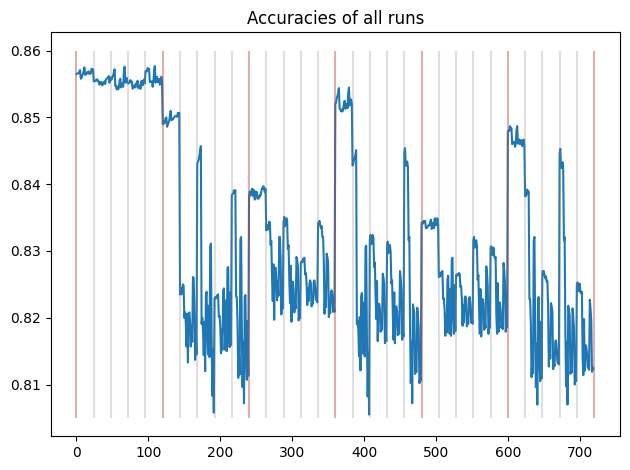

In [72]:
plt.plot(range(720), accuracies)
plt.vlines(x=list(range(0, 721, 120)), ymin=0.805, ymax=0.86, colors='r', alpha=0.25)
plt.vlines(x=list(range(0, 721, 24)), ymin=0.805, ymax=0.86, colors='gray', alpha=0.25)
plt.title("Accuracies of all runs")
plt.tight_layout()
plt.show()

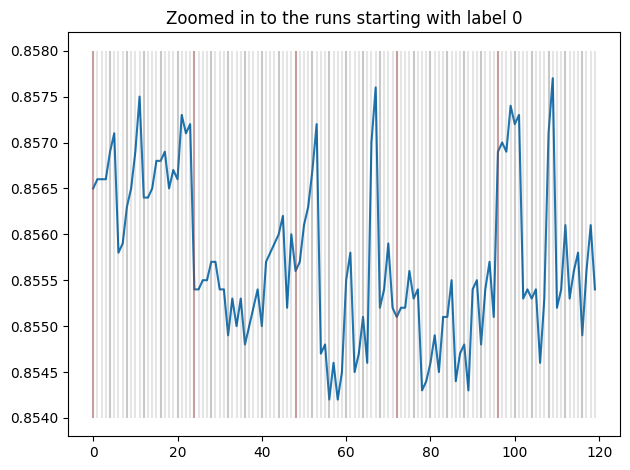

In [76]:
plt.plot(range(120), accuracies[:120])
plt.vlines(x=list(range(0, 120, 24)), ymin=0.854, ymax=0.858, colors='red', alpha=0.25)
plt.vlines(x=list(range(0, 120, 4)), ymin=0.854, ymax=0.858, colors='gray', alpha=0.25)
plt.vlines(x=list(range(0, 120, 1)), ymin=0.854, ymax=0.858, colors='black', alpha=0.1)
plt.title("Zoomed in to the runs starting with label 0")
plt.tight_layout()
plt.show()

In [32]:
with open(f"output/logreg_tf_0_C1_tol0.0001_mi610.txt", 'r') as f:
    print(f.read())

Train/Test datasets: (178839,), (44710,), (178839, 6), (44710, 6)

Shape of features: (178839, 233383), (44710, 233383)

Model Parameters
--------------------
base_estimator: deprecated
chain_method: predict_proba
cv: None
estimator__C: 1
estimator__class_weight: balanced
estimator__dual: False
estimator__fit_intercept: True
estimator__intercept_scaling: 1
estimator__l1_ratio: None
estimator__max_iter: 610
estimator__multi_class: deprecated
estimator__n_jobs: None
estimator__penalty: l2
estimator__random_state: 42
estimator__solver: lbfgs
estimator__tol: 0.0001
estimator__verbose: 0
estimator__warm_start: False
estimator: LogisticRegression(C=1, class_weight='balanced', max_iter=610, random_state=42)
order: (0, 5, 3, 1, 4, 2)
random_state: 42
verbose: False

Training Time: 0.0m 13.384s

Accuracy: 0.8577
               precision    recall  f1-score   support

        toxic       0.60      0.87      0.71      4266
identity_hate       0.19      0.91      0.31       384
       threat      

In [39]:
main([False, 0, 0, 2, 101, 6, 2, 1])

Loading data...
Getting features...
Training model...
Evaluating model...
Script output written to output\rf_tf_0_est101_md6_mss2_msl1.txt


In [41]:
with open("output/rf_tf_0_est100_md6_mss2_msl1.txt", 'r') as f:
    print(f.read())

Train/Test datasets: (178839,), (44710,), (178839, 6), (44710, 6)

Shape of features: (178839, 233383), (44710, 233383)

Model Parameters
--------------------
base_estimator: deprecated
chain_method: predict_proba
cv: None
estimator__bootstrap: True
estimator__ccp_alpha: 0.0
estimator__class_weight: balanced
estimator__criterion: gini
estimator__max_depth: 6
estimator__max_features: sqrt
estimator__max_leaf_nodes: None
estimator__max_samples: None
estimator__min_impurity_decrease: 0.0
estimator__min_samples_leaf: 1
estimator__min_samples_split: 2
estimator__min_weight_fraction_leaf: 0.0
estimator__monotonic_cst: None
estimator__n_estimators: 100
estimator__n_jobs: None
estimator__oob_score: False
estimator__random_state: 42
estimator__verbose: 0
estimator__warm_start: False
estimator: RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=42)
order: [0, 5, 3, 1, 4, 2]
random_state: 42
verbose: False

Training Time: 0.0m 24.000s

Accuracy: 0.5244
               precis

In [42]:
with open("output/rf_tf_0_est101_md6_mss2_msl1.txt", 'r') as f:
    print(f.read())

Train/Test datasets: (178839,), (44710,), (178839, 6), (44710, 6)

Shape of features: (178839, 233383), (44710, 233383)

Model Parameters
--------------------
base_estimator: deprecated
chain_method: predict_proba
cv: None
estimator__bootstrap: True
estimator__ccp_alpha: 0.0
estimator__class_weight: balanced
estimator__criterion: gini
estimator__max_depth: 6
estimator__max_features: sqrt
estimator__max_leaf_nodes: None
estimator__max_samples: None
estimator__min_impurity_decrease: 0.0
estimator__min_samples_leaf: 1
estimator__min_samples_split: 2
estimator__min_weight_fraction_leaf: 0.0
estimator__monotonic_cst: None
estimator__n_estimators: 101
estimator__n_jobs: None
estimator__oob_score: False
estimator__random_state: 42
estimator__verbose: 0
estimator__warm_start: False
estimator: RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=101,
                       random_state=42)
order: [4, 2, 0, 1, 5, 3]
random_state: 42
verbose: False

Training Time: 0.0m 22.802

In [59]:
p = list(permutations(range(6)))
for i in range(120-1):
    if p[i][1] != p[i+1][1]:
        print(f"swapping to {p[i+1][1]} at idx {i+1}")

swapping to 2 at idx 24
swapping to 3 at idx 48
swapping to 4 at idx 72
swapping to 5 at idx 96
